[ 6 12 47 39]


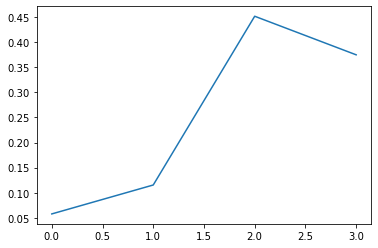

In [89]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt


ALPHABET_SIZE = 2
DELTA = 0.9


def ReadFreq(fn):
    return data

def ReadSeqs(fn):
    return data

freq = np.array([
    [
    #0,0
    [ [0., 0.], [0., 0.] ],
    #0,1
    [ [0.1, 0.2], [0.3, 0.4] ],
    #0,2
    [ [0.05, 0.15], [0.25, 0.55] ]
    ],
    [
    #1,0
    [ [0.1, 0.3], [0.2, 0.4] ],
    #1,1
    [ [0., 0.], [0., 0.] ],
    #1,2
    [ [0.1, 0.3], [0.2, 0.4] ]
    ],
    [
    #2,0
    [ [0.05, 0.25], [0.15, 0.55] ],
    #2,1
    [ [0.1, 0.2], [0.3, 0.4] ],
    #2,2
    [ [0., 0.], [0., 0.] ]
    ]

])
seqs = np.array([ [0, 1, 0] ])

class DCA:
    def __init__(self, freq, seqs, verbose = False, keep_states = False):
        self.PP = freq
        self.s = seqs
        self.L = len(seqs[0])
        self.A = ALPHABET_SIZE
        #self.P = np.zeros((selfL, A, A))
        self.P = self.PP.sum(axis=1)
        
        self.initSeq = 0
        
        self.currentState = np.copy(self.s[ self.initSeq ])
        self.currentDist = 0
        self.H = np.ones(self.L+1, dtype=int)
        
        self.verbose = verbose
        self.keep_states = keep_states
        if self.keep_states:
            self.states = [ np.copy(self.currentState) ]

    def step(self):
        if self.verbose:
            print("STEP")
            print(self.currentState, self.currentDist)
        pos = rnd.choice(self.L)
        weights = np.ones(self.A)
        for pos_i in range(self.L):
            if pos_i == pos:
                continue
            for a in range(self.A):
                weights[a] *= self.PP[pos, pos_i, a, self.currentState[pos_i]]
            weights[a] = weights[a]**DELTA
        if self.verbose:
            print("weights = ", weights)
        new_a = rnd.choice(self.A, p=weights/sum(weights))
        if self.verbose:
            print("pos = ", pos, " new_a = ", new_a)
        if new_a == self.currentState[pos] or (self.currentState[pos] != self.s[ self.initSeq,  pos] and new_a != self.s[ self.initSeq,  pos]):
            newDist = self.currentDist
        elif new_a == self.s[ self.initSeq, pos ]:
            newDist = self.currentDist - 1
        else:
            newDist = self.currentDist + 1
        p = self.H[self.currentDist]/self.H[newDist]
        if p >= 1. or rnd.choice(2, p=[1.-p, p]) == 1:
            self.currentState[pos] = new_a
            self.currentDist = newDist
        self.H[self.currentDist] += 1
        if self.keep_states:
            self.states.append( np.copy(self.currentState) )
        
    def run(self, iterations):
        for i in range(iterations):
            self.step()
            
dca = DCA(freq, seqs, keep_states=True, verbose = False)
dca.run(100)

print(dca.H)

plt.plot(dca.H/sum(dca.H))

In [75]:
import numpy.random as rnd
rnd.choice(5, size= 100)

array([4, 0, 3, 0, 3, 1, 1, 1, 1, 2, 1, 3, 4, 2, 0, 4, 2, 1, 3, 4, 4, 1,
       1, 1, 0, 3, 4, 1, 3, 4, 2, 0, 3, 1, 3, 0, 2, 1, 0, 4, 2, 0, 0, 3,
       4, 3, 0, 4, 0, 2, 1, 3, 4, 3, 0, 0, 4, 2, 1, 2, 4, 0, 4, 3, 1, 3,
       3, 0, 1, 0, 2, 3, 1, 4, 1, 0, 3, 1, 3, 4, 0, 2, 2, 1, 2, 2, 4, 2,
       4, 1, 4, 3, 3, 0, 2, 3, 4, 4, 0, 4])

In [17]:
print(freq)

[[[[0.   0.  ]
   [0.   0.  ]]

  [[0.1  0.9 ]
   [0.8  0.2 ]]

  [[0.3  0.7 ]
   [0.4  0.6 ]]]


 [[[0.1  0.9 ]
   [0.8  0.2 ]]

  [[0.   0.  ]
   [0.   0.  ]]

  [[0.15 0.85]
   [0.45 0.55]]]


 [[[0.3  0.7 ]
   [0.4  0.6 ]]

  [[0.15 0.85]
   [0.45 0.55]]

  [[0.   0.  ]
   [0.   0.  ]]]]


In [35]:
rnd.choice(1, [1.-0.1, 0.1])

TypeError: 'float' object cannot be interpreted as an integer

In [25]:
freq.shape

(3, 3, 2, 2)

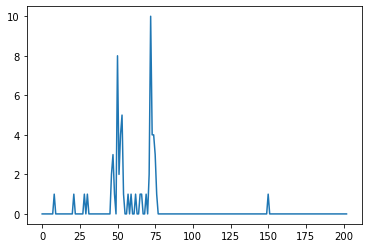

In [122]:
def hamming(s1, s2):
    d = 0
    for i in range(len(s1)):
        if s1[i] != s2[i]:
            d += 1
    return d

fn="sars2_rbd.stat/RBDs_aa_aligned_v3.fasta"
seqs = []
with open(fn) as f:
    for l in f:
        l = l.rstrip()
        if l[0] == ">":
            name = l[1:]
            s = ""
        elif len(l) > 30:
            s = s+l
        else:
            s = s+l
            seqs.append([name, s])
seqs = np.array(seqs)
L = len(seqs[0,1])
sid = 0
G = np.zeros(L, dtype = "int")

for i in range(len(seqs)):
    if i == sid:
        continue
    n = hamming(seqs[sid, 1], seqs[i, 1])
    G[n] += 1
    
plt.plot(G)
    

In [190]:
fn="sars2_rbd.stat/RBDs_aa_aligned_v3/RBDs_aa_aligned_v3.fij_ab"

ALPHABET_SIZE = 21

freq = np.zeros((L,L,ALPHABET_SIZE,ALPHABET_SIZE))

print("seq len = ", L)

with open(fn) as f:
    for l in f:
        if l[0:4]=="site":
            l = l.rstrip()
            l = l.split("\t")
            continue
        l = l.rstrip()
        if l == '':
            continue
        lll = l.split("\t")
        site1, site2 = int(lll[0])-1, int(lll[1])-1
        fr = np.array( [float(x) for x in lll[2:2+ALPHABET_SIZE*ALPHABET_SIZE]] )
        fr = np.reshape(fr, (ALPHABET_SIZE,ALPHABET_SIZE) )

            
        freq[site1, site2, ] = fr
        freq[site2, site1, ] = fr


seq len =  203


In [191]:
fn="sars2_rbd.stat/RBDs_aa_aligned_v3/RBDs_aa_aligned_v3.fi_a"

ALPHABET_SIZE = 21

print("seq len = ", L)

with open(fn) as f:
    for l in f:
        if l[0:4]=="site":
            continue
        l = l.rstrip()
        if l == '':
            continue
        lll = l.split("\t")
        site1 = int(lll[0])-1
        fr = np.array( [float(x) for x in lll[1:1+ALPHABET_SIZE]] )
        for i in range(ALPHABET_SIZE):
            freq[site1, site1, i, i] = fr[i]

seq len =  203


In [192]:
sum(sum(freq[202,201]))

0.999816